This notebook qualitatively compares different method to expose synthetic artifacts.

We included the functions from ../code to show how each method expose these features.

Note that, we had to reimplement the functions here, since we are not interesting in extracting the artifacts (using GLCM feats, or FFT Peaks),
but solely visually compare them.


In [38]:
# Show the presence of sampling artifacts on synthetic data.
%load_ext autoreload
%autoreload 2

import numpy as np
from skimage.feature import graycomatrix
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import sys
sys.path.append('../code')
from dataset import Dataset
from artifacts import image_patches, dft
from utils import load_img
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

def patch_fourier( img: np.ndarray, 
                            patch_size=64,
                            eps=1e-6) -> np.ndarray:
    """
    Exact same function from ../code/artifact, but without extracting the FFT-PEAKS.
    Input image should be in grayscale.
    """

    # Image normalization and float casting.
    img_p = img / 255.0
    H = np.ones((3,3), dtype=np.float32) / 8
    H[2, 2] = 0

    # Compute the residual image.
    res = img_p - convolve2d(img_p, H, mode='same', boundary='symm')

    # Compute the 2D Fourier transform of the image
    patches = image_patches(res, patch_height=patch_size, patch_width=patch_size)
    patches_fourier = [dft(patch) for patch in patches]

    # Normalize patches dft
    for i, _ in enumerate(patches_fourier):
        patch_h, patch_w = patches_fourier[i].shape
        patches_fourier[i] = patches_fourier[i] / (patch_h * patch_w)
    
    patch_average = np.array(patches_fourier).mean(axis=0)

    return patch_average 

def fourier(img: np.ndarray) -> np.ndarray:
    """
    Exact same function dft from ../code, using the Mean kernel to extract
    the residual

    Input image should be in grayscale.
    """

    # Image normalization and float casting.
    img_p = img / 255.0
    H = np.ones((3,3), dtype=np.float32) / 8
    H[2, 2] = 0

    # Compute the residual image.
    res = img_p - convolve2d(img_p, H, mode='same', boundary='symm')

    # Compute the 2D Fourier transform of the image
    res_fourier = dft(res)

    # Normalize dft
    h, w = res_fourier.shape
    res_fourier = res_fourier / (h*w)
    
    return res_fourier

def glcm(img):
    """
    Computes the co-occurrence matrix of the residual image.
    Input image should be in grayscale.
    """

    # Image normalization and float casting.
    img_p = img / 255.0
    H = np.ones((3,3), dtype=np.float32) / 8
    H[2, 2] = 0

    # Compute the residual image.
    res = img_p - convolve2d(img_p, H, mode='same', boundary='symm')

    # Normalization to cast back to uint8
    res -= np.min(res)
    res /= (np.max(res)+1e-6)
    res *= 255
    res[res < 0] = 0
    res[res > 255] = 255
    res = res.astype(np.uint8)

    # Compute the co-occurrence matrix
    glcm = graycomatrix(res,
                      levels=256,
                      distances=[4],
                      angles=[0],
                      symmetric=True,
                      normed=True)
    
    return glcm.squeeze()


def fft_glcm(img):
    """
    Calculates the FFT of the GLCM of the residual image.
    Input image should be in grayscale.
    """
    
    # Computes the GLCM of the residual image and its FFT
    fft_img = dft(glcm(img))
    # Normalization
    fft_img = fft_img / (fft_img.shape[0] * fft_img.shape[1])

    return fft_img


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Read Dataset
dataset = Dataset(classes = ["real", "cyclegan", "ddpm", "stylegan2ada",
                            "pix2pix"])
dataset = dataset.dataset
dataset = dataset.groupby("type").apply(lambda x: x.sample(100, random_state=42)).reset_index(drop=True)

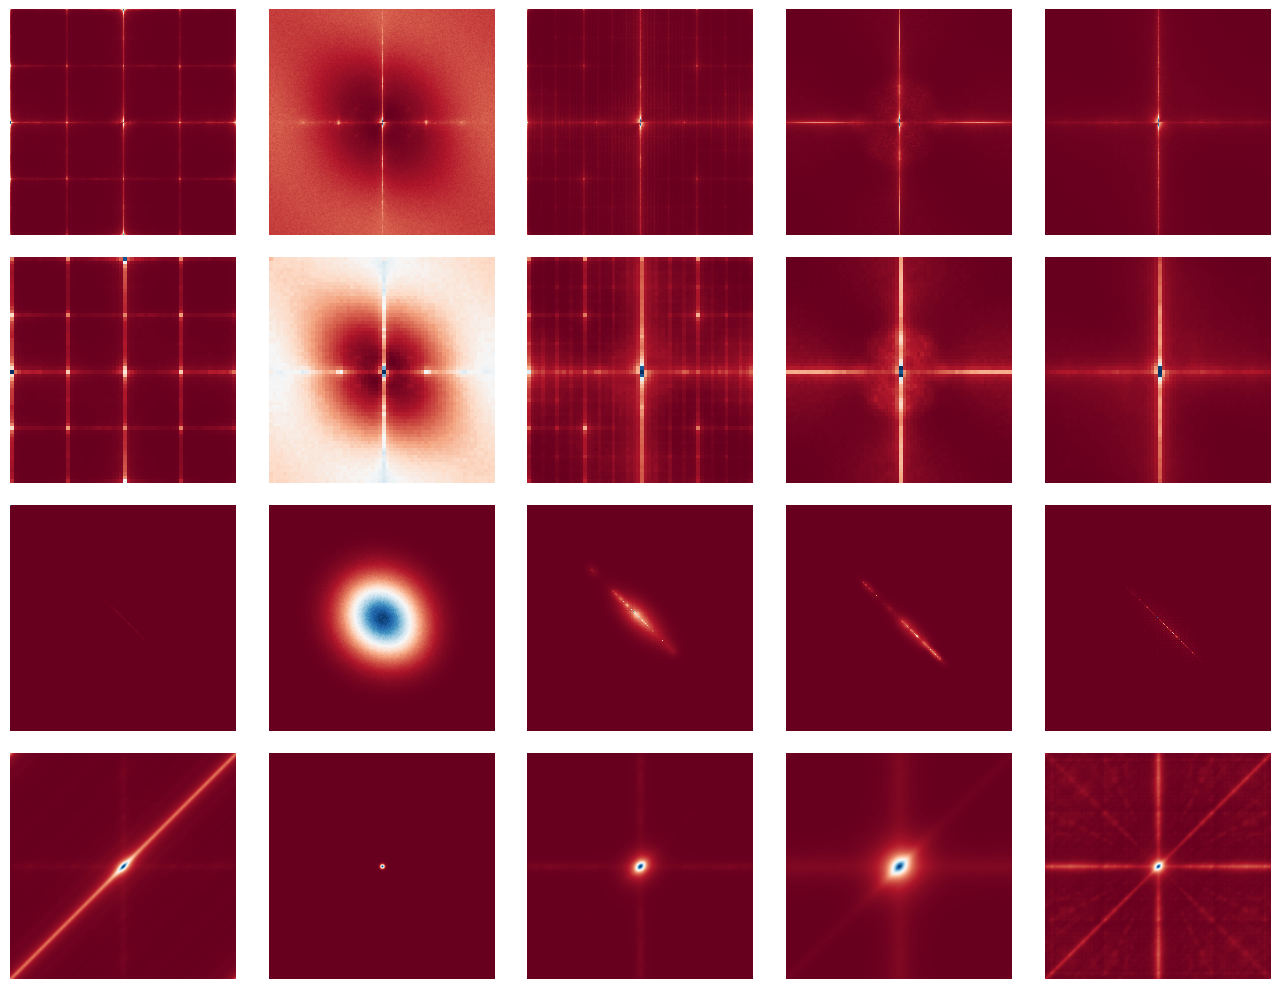

In [39]:
fig, axs = plt.subplots(4, 5, figsize=(13, 10))
axs = axs.ravel()
i = 0
generators_names = {'cyclegan': 'CycleGAN',
                    'ddpm': 'DDPM',
                    'stylegan2ada': 'StyleGAN2-ADA',
                    'pix2pix': 'Pix2Pix',
                    'real': 'Real'}

image_types = list(dataset["type"].unique())
# sort image types by generator name sorted items
items_sorted = sorted(generators_names.items(), key=lambda x: x[1])
image_types = ['cyclegan', 'ddpm', 'pix2pix', 'stylegan2ada', 'real']

row_labels = ['Fourier', 'Patched Fourier', 'GLCM', 'FFT-GLCM']
col_labels = [generators_names[gen] for gen in image_types]

def plot_image(ax, img_type, func, size):
    avg_result = np.zeros((size, size))
    for idx, row in dataset[dataset["type"] == img_type].iterrows():
        img = load_img(row["path"])
        avg_result += func(img)
    avg_result /= 100
    ax.imshow(avg_result, cmap="RdBu")
    ax.axis("off")

# Plot images
for row in range(4):
    for col, img_type in enumerate(image_types):
        if row == 0:
            plot_image(axs[i], img_type, fourier, 256)
        elif row == 1:
            plot_image(axs[i], img_type, patch_fourier, 64)
        elif row == 2:
            plot_image(axs[i], img_type, glcm, 256)
        elif row == 3:
            plot_image(axs[i], img_type, fft_glcm, 256)
        if row == 0:
            axs[i].set_title(col_labels[col], fontsize=12)
        i += 1

# Add row labels using fig.text
for row, label in enumerate(row_labels):
    fig.text(0.11, 0.8 - (row * 0.20), label, va='center', ha='center', fontsize=12, rotation=90)


plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("spectrum_residuum_with_legend.png", dpi=200)
plt.show()